In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Maranhão - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_MA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Maranhão - Desemprego,Maranhão - Consumo de Cimento (t),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado
0,2003-1,23.368400,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.213662,43.342,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07
1,2003-2,23.167977,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.207986,28.663,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07
2,2003-3,23.563273,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.202310,27.900,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07
3,2003-4,24.008345,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.196633,25.739,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07
4,2003-5,24.366896,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.190957,30.203,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,31.724066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.698,0.520178,NaN,NaN,NaN,NaN,NaN
236,2022-9,31.679231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.133,0.518515,NaN,NaN,NaN,NaN,NaN
237,2022-10,31.524870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.964,0.516447,NaN,NaN,NaN,NaN,NaN
238,2022-11,31.512212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.684,0.513912,NaN,NaN,NaN,NaN,NaN


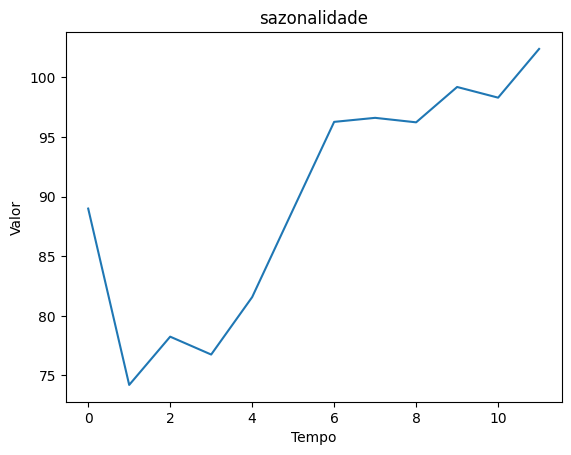

,sazonalidade
sazonalidade,
0,88.993143
1,74.209214
2,78.255250
3,76.756071
4,81.571857
5,88.929857
6,96.263929
7,96.601857
8,96.225714


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Maranhão - Desemprego,Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,sazonalidade,Maranhão - Consumo de Cimento (t)
0,2003-1,23.368400,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.213662,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,88.993143,43.342
1,2003-2,23.167977,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.207986,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,74.209214,28.663
2,2003-3,23.563273,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.202310,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,78.255250,27.900
3,2003-4,24.008345,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.196633,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,76.756071,25.739
4,2003-5,24.366896,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.190957,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,81.571857,30.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,31.724066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520178,NaN,NaN,NaN,NaN,NaN,96.601857,102.698
236,2022-9,31.679231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.518515,NaN,NaN,NaN,NaN,NaN,96.225714,98.133
237,2022-10,31.524870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516447,NaN,NaN,NaN,NaN,NaN,99.189714,94.964
238,2022-11,31.512212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.513912,NaN,NaN,NaN,NaN,NaN,98.294429,97.684


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.124
1      39.810
2      44.937
3      41.661
4      47.350
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Maranhão - Consumo de Cimento (t), Length: 240, dtype: float64

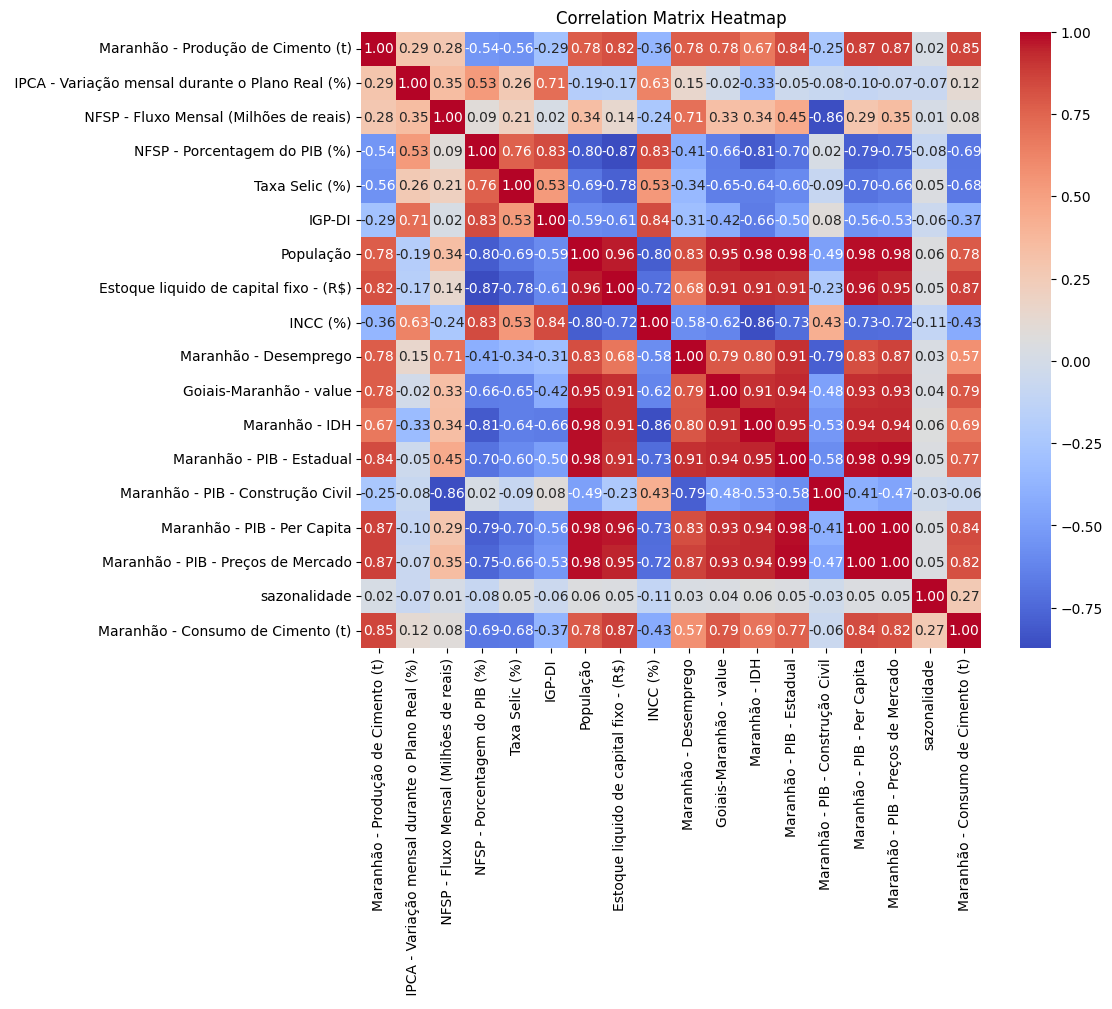

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Maranhão - Produção de Cimento (t),5.497886e+03
1,IPCA - Variação mensal durante o Plano Real (%),1.107716e+03
2,NFSP - Fluxo Mensal (Milhões de reais),3.371981e+02
3,NFSP - Porcentagem do PIB (%),3.653602e+02
4,Taxa Selic (%),5.627894e+01
5,IGP-DI,3.151793e+02
6,População,1.304451e+07
7,Estoque liquido de capital fixo - (R$),8.522005e+06
8,INCC (%),1.623419e+03
9,Maranhão - Desemprego,7.962179e+03


In [39]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 3


,Maranhão - Produção de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Maranhão - Desemprego,Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,sazonalidade
0,23.368400,0.724032,-5331.049150,11.520143,1.639718,1.036534,7.330309e+06,0.969649,8.213662,0.260097,0.635570,4.315322e+07,2.636001e+06,88.993143
1,23.167977,0.690297,-5318.079644,11.189862,1.378899,0.993449,7.335910e+06,0.950783,8.207986,0.258964,0.635997,4.320832e+07,2.636851e+06,74.209214
2,23.563273,0.669681,-5436.417870,10.820792,1.924317,0.973020,7.341511e+06,0.938332,8.202310,0.257352,0.636424,4.326343e+07,2.637701e+06,78.255250
3,24.008345,0.660494,-5707.015274,10.417840,1.331174,0.940489,7.347112e+06,0.926401,8.196633,0.255929,0.636851,4.331853e+07,2.638551e+06,76.756071
4,24.366896,0.648337,-5599.317941,9.959690,1.736072,0.917493,7.352713e+06,0.951683,8.190957,0.254109,0.637278,4.337364e+07,2.639401e+06,81.571857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,35.722671,0.366904,-5783.316460,2.206994,0.545067,0.471521,7.783063e+06,0.378150,12.377711,0.374870,0.677409,5.216675e+07,2.561849e+06,96.601857
176,34.933872,0.358935,-6001.730740,2.215328,0.782910,0.476827,7.780841e+06,0.377666,12.365936,0.375507,0.677355,5.216034e+07,2.562159e+06,96.225714
177,34.493738,0.354313,-6454.887704,2.232466,0.909682,0.475427,7.778619e+06,0.377838,12.354161,0.376148,0.677300,5.215393e+07,2.562469e+06,99.189714
178,33.966493,0.352728,-6243.191421,2.263185,1.050614,0.491301,7.776397e+06,0.370057,12.342386,0.376801,0.677245,5.214751e+07,2.562779e+06,98.294429


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Maranhão - Desemprego,Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-0.755929,-0.886364,-2.142621,-1.626226,-0.407800
1,2.402642,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-0.758809,-0.907289,-2.105177,-1.608286,-0.389752
2,2.158351,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-0.761688,-0.937020,-2.067732,-1.590346,-0.371704
3,2.049492,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-0.764567,-0.963285,-2.030288,-1.572407,-0.353656
4,1.905441,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-0.767447,-0.996868,-1.992843,-1.554467,-0.335607
...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,0.605679,-1.872446,1.356270,1.231466,1.526310,1.308185,-1.982129
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,0.591420,-1.876611,1.350297,1.243232,1.521522,1.306097,-1.975548
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,0.577161,-1.875135,1.344324,1.255063,1.516733,1.304009,-1.968968
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,0.562902,-1.942040,1.338352,1.267112,1.511944,1.301921,-1.962388


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Maranhão - Desemprego,Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-0.755929,-0.886364,-2.142621,-1.626226,-0.407800
1,2.402642,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-0.758809,-0.907289,-2.105177,-1.608286,-0.389752
2,2.158351,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-0.761688,-0.937020,-2.067732,-1.590346,-0.371704
3,2.049492,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-0.764567,-0.963285,-2.030288,-1.572407,-0.353656
4,1.905441,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-0.767447,-0.996868,-1.992843,-1.554467,-0.335607
...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,0.759879,-1.491033,1.461955,1.097275,1.566555,1.308038,-1.936001
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,0.749001,-1.525186,1.449180,1.105888,1.565210,1.310991,-1.954439
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,0.738124,-1.546744,1.436404,1.114449,1.563866,1.313944,-1.972877
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,0.727246,-1.586381,1.423629,1.122956,1.562521,1.316897,-1.991315


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      56.124
1      39.810
2      44.937
3      41.661
4      47.350
        ...  
163    73.445
164    69.471
165    83.004
166    77.332
167    58.591
Name: Maranhão - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 12)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Maranhão - Desemprego,Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.965586,-0.066954,1.157840,0.850601,0.516874,1.032965,-0.081026
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.962419,-0.130652,1.180790,0.854655,0.518639,1.044554,-0.166961
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.959252,-0.079602,1.203739,0.858521,0.520403,1.056144,-0.252896
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.956085,-0.034473,1.226689,0.866037,0.522168,1.067733,-0.338831
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.952918,-0.177535,1.249638,0.873515,0.523933,1.079323,-0.424766
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.949751,-0.208868,1.272588,0.881758,0.525697,1.090912,-0.510701
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.946584,-0.245300,1.295538,0.896585,0.527462,1.102502,-0.596635
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.943417,-0.333490,1.318487,0.907739,0.529227,1.114091,-0.682570
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.940250,-0.296846,1.341437,0.918912,0.530992,1.125681,-0.768505
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.937082,-0.292462,1.364386,0.930119,0.532756,1.137270,-0.854440


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 12)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3311012191, 1503797457, 3905497913, 2323684171, 2708560051, 601233751, 1297420863, 4257236933, 935550348, 2725751188]


Step: 0 ___________________________________________
val_loss: 163.02764892578125
winner_seed: 3311012191


Step: 1 ___________________________________________
val_loss: 161.512451171875
winner_seed: 1503797457


Step: 2 ___________________________________________
val_loss: 481.0821228027344


Step: 3 ___________________________________________
val_loss: 247.49954223632812


Step: 4 ___________________________________________
val_loss: 430.74530029296875


Step: 5 ___________________________________________
val_loss: 114.8625717163086
winner_seed: 601233751


Step: 6 ___________________________________________
val_loss: 439.20819091796875


Step: 7 ___________________________________________
val_loss: 156.33975219726562


Step: 8 ___________________________________________
val_loss: 217.67849731445312


Step: 9 ___________________________________________
val_loss: 326

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 394904081

Epoch 1/10000
4/4 [==============================] - 2s 139ms/step - loss: 8579.1270 - val_loss: 2065.8708
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 596.1685 - val_loss: 2450.5774
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 581.0551 - val_loss: 1048.9985
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 623.7604 - val_loss: 1892.2281
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 524.4378 - val_loss: 814.6334
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 417.9982 - val_loss: 817.7930
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 685.2543 - val_loss: 2016.5105
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 595.0544 - val_loss: 787.8234
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 315.1132 - val_loss: 478.2068
Epoch 10/10000
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 11ms/step - loss: 135.1867 - val_loss: 156.3883
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 146.5140 - val_loss: 230.0744
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 136.0094 - val_loss: 232.0780
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 132.8233 - val_loss: 359.4601
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 137.6446 - val_loss: 305.5769
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 145.6220 - val_loss: 286.2252
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 138.7211 - val_loss: 175.7135
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 129.6175 - val_loss: 203.8171
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 150.7438 - val_loss: 230.8698
Epoch 88/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 95.5420 - val_loss: 627.6322
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.4779 - val_loss: 587.8386
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 108.8975 - val_loss: 609.7379
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.4887 - val_loss: 693.9499
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.5166 - val_loss: 812.1551
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 104.1363 - val_loss: 868.4700
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 109.1241 - val_loss: 785.2107
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 107.0412 - val_loss: 551.9315
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 115.3227 - val_loss: 375.7345
Epoch 165/10000
4/4 [==============================] - 0s 11ms/ste

4/4 [==============================] - 0s 11ms/step - loss: 99.6434 - val_loss: 1721.9176
Epoch 234/10000
4/4 [==============================] - 0s 13ms/step - loss: 116.0961 - val_loss: 1147.9969
Epoch 235/10000
4/4 [==============================] - 0s 12ms/step - loss: 131.3090 - val_loss: 1752.1868
Epoch 236/10000
4/4 [==============================] - 0s 13ms/step - loss: 94.4625 - val_loss: 1396.6423
Epoch 237/10000
4/4 [==============================] - 0s 11ms/step - loss: 91.0306 - val_loss: 1620.9545
Epoch 238/10000
4/4 [==============================] - 0s 12ms/step - loss: 82.6634 - val_loss: 1240.6405
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 91.3817 - val_loss: 1242.4900
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 91.5456 - val_loss: 1492.3352
Epoch 241/10000
4/4 [==============================] - 0s 11ms/step - loss: 77.2459 - val_loss: 1707.7737
Epoch 242/10000
4/4 [==============================] - 0s 11

4/4 [==============================] - 0s 9ms/step - loss: 121.0105 - val_loss: 1982.6140
Epoch 311/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.4673 - val_loss: 1557.2780
Epoch 312/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.2615 - val_loss: 1207.5522
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 82.2842 - val_loss: 1519.4177
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 103.4671 - val_loss: 1282.9777
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 65.7742 - val_loss: 1262.0439
Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.0145 - val_loss: 1074.6346
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 65.2678 - val_loss: 958.6295
Epoch 318/10000
4/4 [==============================] - 0s 10ms/step - loss: 72.3058 - val_loss: 916.0759
Epoch 319/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 11ms/step - loss: 180.5668 - val_loss: 1370.2909
Epoch 388/10000
4/4 [==============================] - 0s 11ms/step - loss: 168.2385 - val_loss: 1597.1826
Epoch 389/10000
4/4 [==============================] - 0s 10ms/step - loss: 111.5336 - val_loss: 1569.5862
Epoch 390/10000
4/4 [==============================] - 0s 12ms/step - loss: 95.0195 - val_loss: 1188.9540
Epoch 391/10000
4/4 [==============================] - 0s 11ms/step - loss: 85.2840 - val_loss: 1457.5529
Epoch 392/10000
4/4 [==============================] - 0s 12ms/step - loss: 98.1430 - val_loss: 1415.1110
Epoch 393/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.4636 - val_loss: 1114.8213
Epoch 394/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.8640 - val_loss: 1362.6339
Epoch 395/10000
4/4 [==============================] - 0s 12ms/step - loss: 65.4194 - val_loss: 1489.6139
Epoch 396/10000
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 11ms/step - loss: 39.0627 - val_loss: 1341.1135
Epoch 465/10000
4/4 [==============================] - 0s 11ms/step - loss: 37.8634 - val_loss: 1579.5369
Epoch 466/10000
4/4 [==============================] - 0s 12ms/step - loss: 39.0540 - val_loss: 1312.1017
Epoch 467/10000
4/4 [==============================] - 0s 12ms/step - loss: 34.7439 - val_loss: 1091.1359
Epoch 468/10000
4/4 [==============================] - 0s 12ms/step - loss: 39.9608 - val_loss: 1022.0594
Epoch 469/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.5349 - val_loss: 1067.9609
Epoch 470/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.2823 - val_loss: 1368.8312
Epoch 471/10000
4/4 [==============================] - 0s 12ms/step - loss: 32.3826 - val_loss: 1145.7351
Epoch 472/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.1077 - val_loss: 1309.0420
Epoch 473/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 22.7255 - val_loss: 1075.7122
Epoch 542/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.3436 - val_loss: 1127.4550
Epoch 543/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.4224 - val_loss: 1129.8322
Epoch 544/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.3272 - val_loss: 1269.6600
Epoch 545/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.8082 - val_loss: 1024.2032
Epoch 546/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.0949 - val_loss: 1071.3762
Epoch 547/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.6945 - val_loss: 1072.1072
Epoch 548/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.6904 - val_loss: 1008.1877
Epoch 549/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.9552 - val_loss: 976.9874
Epoch 550/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 11ms/step - loss: 97.1464 - val_loss: 1045.0286
Epoch 619/10000
4/4 [==============================] - 0s 11ms/step - loss: 56.1984 - val_loss: 715.4563
Epoch 620/10000
4/4 [==============================] - 0s 11ms/step - loss: 49.6707 - val_loss: 817.3529
Epoch 621/10000
4/4 [==============================] - 0s 12ms/step - loss: 60.5930 - val_loss: 442.3941
Epoch 622/10000
4/4 [==============================] - 0s 12ms/step - loss: 58.4158 - val_loss: 305.4712
Epoch 623/10000
4/4 [==============================] - 0s 11ms/step - loss: 107.8018 - val_loss: 348.9457
Epoch 624/10000
4/4 [==============================] - 0s 12ms/step - loss: 76.6132 - val_loss: 397.9670
Epoch 625/10000
4/4 [==============================] - 0s 11ms/step - loss: 100.1381 - val_loss: 354.9733
Epoch 626/10000
4/4 [==============================] - 0s 11ms/step - loss: 55.2778 - val_loss: 358.6768
Epoch 627/10000
4/4 [==============================] - 0s 12ms/step 

4/4 [==============================] - 0s 11ms/step - loss: 18.2667 - val_loss: 256.4267
Epoch 697/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.4184 - val_loss: 209.5859
Epoch 698/10000
4/4 [==============================] - 0s 13ms/step - loss: 24.1871 - val_loss: 257.8224
Epoch 699/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.6659 - val_loss: 226.8462
Epoch 700/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.4699 - val_loss: 461.3486
Epoch 701/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.7724 - val_loss: 219.2301
Epoch 702/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.1699 - val_loss: 251.9041
Epoch 703/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.8765 - val_loss: 249.0610
Epoch 704/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.8754 - val_loss: 235.5887
Epoch 705/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 13.1209 - val_loss: 264.8326
Epoch 775/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.1109 - val_loss: 282.6231
Epoch 776/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.8727 - val_loss: 365.6187
Epoch 777/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.3921 - val_loss: 253.7233
Epoch 778/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.6073 - val_loss: 230.8629
Epoch 779/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.4122 - val_loss: 416.2492
Epoch 780/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.4674 - val_loss: 239.3409
Epoch 781/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.1261 - val_loss: 241.8127
Epoch 782/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.0756 - val_loss: 291.9332
Epoch 783/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 13.4280 - val_loss: 287.6328
Epoch 853/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.6273 - val_loss: 261.4063
Epoch 854/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.9267 - val_loss: 576.9181
Epoch 855/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.4166 - val_loss: 808.7761
Epoch 856/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.0930 - val_loss: 276.3457
Epoch 857/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.2593 - val_loss: 627.8225
Epoch 858/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.6460 - val_loss: 270.8145
Epoch 859/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.0661 - val_loss: 566.1167
Epoch 860/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.3640 - val_loss: 532.7513
Epoch 861/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 11.5402 - val_loss: 242.6311
Epoch 931/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.1425 - val_loss: 249.9167
Epoch 932/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.5158 - val_loss: 196.5812
Epoch 933/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.8002 - val_loss: 235.4928
Epoch 934/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.7590 - val_loss: 222.9748
Epoch 935/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.8307 - val_loss: 228.2758
Epoch 936/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.6187 - val_loss: 268.2855
Epoch 937/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.2299 - val_loss: 245.3213
Epoch 938/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.0197 - val_loss: 241.4753
Epoch 939/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 11.1354 - val_loss: 204.8584
Epoch 1009/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.9902 - val_loss: 234.8518
Epoch 1010/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.0521 - val_loss: 259.4771
Epoch 1011/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.8445 - val_loss: 244.9679
Epoch 1012/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.2729 - val_loss: 237.3291
Epoch 1013/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.2070 - val_loss: 249.2116
Epoch 1014/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.1518 - val_loss: 237.7033
Epoch 1015/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.3113 - val_loss: 222.5662
Epoch 1016/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.9397 - val_loss: 238.5038
Epoch 1017/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 11ms/step - loss: 11.3959 - val_loss: 231.9715
Epoch 1086/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8573 - val_loss: 245.3451
Epoch 1087/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.6237 - val_loss: 220.0754
Epoch 1088/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.5957 - val_loss: 203.0025
Epoch 1089/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.4170 - val_loss: 215.0427
Epoch 1090/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8363 - val_loss: 199.7224
Epoch 1091/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8360 - val_loss: 226.5290
Epoch 1092/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8235 - val_loss: 235.7194
Epoch 1093/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.3056 - val_loss: 239.9798
Epoch 1094/10000
4/4 [==============================] - 0s 13ms/step

Epoch 1163/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.8021 - val_loss: 222.7758
Epoch 1164/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.6410 - val_loss: 218.2843
Epoch 1165/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.1154 - val_loss: 240.4615
Epoch 1166/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.2864 - val_loss: 222.3772
Epoch 1167/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.9813 - val_loss: 221.7226
Epoch 1168/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.8930 - val_loss: 233.3837
Epoch 1169/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.1085 - val_loss: 240.6377
Epoch 1170/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.1047 - val_loss: 247.6205
Epoch 1171/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.8992 - val_loss: 243.4627
Epoch 1172/10000
4/4 [==============================] 

Epoch 1241/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.1819 - val_loss: 237.9476
Epoch 1242/10000
4/4 [==============================] - 0s 14ms/step - loss: 7.5099 - val_loss: 232.4477
Epoch 1243/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.9773 - val_loss: 219.4267
Epoch 1244/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.9184 - val_loss: 236.4245
Epoch 1245/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.6671 - val_loss: 256.9694
Epoch 1246/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.9244 - val_loss: 277.9035
Epoch 1247/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8581 - val_loss: 276.3406
Epoch 1248/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.1667 - val_loss: 256.1739
Epoch 1249/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5241 - val_loss: 256.1079
Epoch 1250/10000
4/4 [==============================] 

Epoch 1319/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3535 - val_loss: 245.9348
Epoch 1320/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5668 - val_loss: 254.4334
Epoch 1321/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.7235 - val_loss: 245.8785
Epoch 1322/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.0735 - val_loss: 231.8297
Epoch 1323/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5632 - val_loss: 211.9506
Epoch 1324/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5411 - val_loss: 218.5057
Epoch 1325/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.2545 - val_loss: 218.8855
Epoch 1326/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5694 - val_loss: 213.3908
Epoch 1327/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8807 - val_loss: 232.3648
Epoch 1328/10000
4/4 [==============================] 

Epoch 1397/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.1875 - val_loss: 191.3602
Epoch 1398/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0835 - val_loss: 205.4913
Epoch 1399/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.3412 - val_loss: 202.2861
Epoch 1400/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0100 - val_loss: 183.6979
Epoch 1401/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.8242 - val_loss: 201.1862
Epoch 1402/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.1700 - val_loss: 216.1246
Epoch 1403/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.6142 - val_loss: 183.5510
Epoch 1404/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5177 - val_loss: 186.1828
Epoch 1405/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.5573 - val_loss: 208.6404
Epoch 1406/10000
4/4 [==============================]

Epoch 1475/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0363 - val_loss: 210.9765
Epoch 1476/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5439 - val_loss: 191.4380
Epoch 1477/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.6986 - val_loss: 163.6123
Epoch 1478/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.1953 - val_loss: 159.0248
Epoch 1479/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5070 - val_loss: 161.1626
Epoch 1480/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.7450 - val_loss: 180.2420
Epoch 1481/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1205 - val_loss: 166.1417
Epoch 1482/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.1201 - val_loss: 166.9324
Epoch 1483/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.9941 - val_loss: 185.3738
Epoch 1484/10000
4/4 [==============================] -

Epoch 1553/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.3428 - val_loss: 157.5936
Epoch 1554/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4033 - val_loss: 172.8724
Epoch 1555/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.3966 - val_loss: 152.1564
Epoch 1556/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4032 - val_loss: 169.2743
Epoch 1557/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8895 - val_loss: 171.4569
Epoch 1558/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.2712 - val_loss: 174.1750
Epoch 1559/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.6617 - val_loss: 167.6709
Epoch 1560/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5855 - val_loss: 155.6129
Epoch 1561/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.6340 - val_loss: 155.3280
Epoch 1562/10000
4/4 [==============================] 

4/4 [==============================] - 0s 11ms/step - loss: 7.3313 - val_loss: 181.2992
Epoch 1632/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9084 - val_loss: 192.9870
Epoch 1633/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.7381 - val_loss: 175.5363
Epoch 1634/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.0546 - val_loss: 167.7155
Epoch 1635/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3350 - val_loss: 178.7019
Epoch 1636/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.5546 - val_loss: 190.0390
Epoch 1637/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8778 - val_loss: 179.1912
Epoch 1638/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4517 - val_loss: 189.7560
Epoch 1639/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.7653 - val_loss: 191.5836
Epoch 1640/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 5.9049 - val_loss: 181.0623
Epoch 1710/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9856 - val_loss: 178.3705
Epoch 1711/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.6384 - val_loss: 168.5302
Epoch 1712/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.3849 - val_loss: 170.3431
Epoch 1713/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.0164 - val_loss: 183.2619
Epoch 1714/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.9761 - val_loss: 175.8710
Epoch 1715/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0012 - val_loss: 173.3065
Epoch 1716/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.1661 - val_loss: 170.9671
Epoch 1717/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4996 - val_loss: 164.5936
Epoch 1718/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 6.6521 - val_loss: 163.1918
Epoch 1788/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5361 - val_loss: 176.2854
Epoch 1789/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.0973 - val_loss: 179.0715
Epoch 1790/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.0555 - val_loss: 166.1333
Epoch 1791/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.3595 - val_loss: 153.7054
Epoch 1792/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.8876 - val_loss: 170.6147
Epoch 1793/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5778 - val_loss: 180.3993
Epoch 1794/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.9769 - val_loss: 158.2388
Epoch 1795/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.4457 - val_loss: 152.6961
Epoch 1796/10000
4/4 [==============================] - 0s 11ms/step - l

Epoch 1865/10000
4/4 [==============================] - 0s 12ms/step - loss: 277.3984 - val_loss: 324.8502
Epoch 1866/10000
4/4 [==============================] - 0s 11ms/step - loss: 265.8064 - val_loss: 320.8907
Epoch 1867/10000
4/4 [==============================] - 0s 10ms/step - loss: 276.3553 - val_loss: 214.1998
Epoch 1868/10000
4/4 [==============================] - 0s 12ms/step - loss: 310.1145 - val_loss: 323.3494
Epoch 1869/10000
4/4 [==============================] - 0s 12ms/step - loss: 269.4545 - val_loss: 627.6375
Epoch 1870/10000
4/4 [==============================] - 0s 12ms/step - loss: 333.4048 - val_loss: 368.5039
Epoch 1871/10000
4/4 [==============================] - 0s 13ms/step - loss: 249.1181 - val_loss: 277.9213
Epoch 1872/10000
4/4 [==============================] - 0s 11ms/step - loss: 287.8286 - val_loss: 221.6501
Epoch 1873/10000
4/4 [==============================] - 0s 12ms/step - loss: 258.1460 - val_loss: 278.1847
Epoch 1874/10000
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 186.5507 - val_loss: 336.6844
Epoch 1942/10000
4/4 [==============================] - 0s 11ms/step - loss: 171.7085 - val_loss: 385.0726
Epoch 1943/10000
4/4 [==============================] - 0s 11ms/step - loss: 189.1431 - val_loss: 418.0386
Epoch 1944/10000
4/4 [==============================] - 0s 12ms/step - loss: 192.1104 - val_loss: 368.6530
Epoch 1945/10000
4/4 [==============================] - 0s 11ms/step - loss: 196.0104 - val_loss: 357.9710
Epoch 1946/10000
4/4 [==============================] - 0s 11ms/step - loss: 180.3510 - val_loss: 357.4587
Epoch 1947/10000
4/4 [==============================] - 0s 10ms/step - loss: 193.3307 - val_loss: 260.5185
Epoch 1948/10000
4/4 [==============================] - 0s 12ms/step - loss: 193.6790 - val_loss: 325.1542
Epoch 1949/10000
4/4 [==============================] - 0s 12ms/step - loss: 221.4686 - val_loss: 258.7053
Epoch 1950/10000
4/4 [==============================] 

4/4 [==============================] - 0s 11ms/step - loss: 179.4738 - val_loss: 232.8880
Epoch 2018/10000
4/4 [==============================] - 0s 10ms/step - loss: 154.2667 - val_loss: 228.2202
Epoch 2019/10000
4/4 [==============================] - 0s 10ms/step - loss: 175.2527 - val_loss: 214.7100
Epoch 2020/10000
4/4 [==============================] - 0s 11ms/step - loss: 150.3380 - val_loss: 332.0604
Epoch 2021/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.1798 - val_loss: 356.5477
Epoch 2022/10000
4/4 [==============================] - 0s 9ms/step - loss: 145.8058 - val_loss: 234.4749
Epoch 2023/10000
4/4 [==============================] - 0s 10ms/step - loss: 141.1864 - val_loss: 284.4364
Epoch 2024/10000
4/4 [==============================] - 0s 10ms/step - loss: 151.7613 - val_loss: 270.5487
Epoch 2025/10000
4/4 [==============================] - 0s 11ms/step - loss: 137.3042 - val_loss: 216.6901
Epoch 2026/10000
4/4 [==============================] -

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.736679,71.687729,73.46714,75.945351,80.043686,84.276543,82.386841,86.86573,88.30645,87.448128,85.086731,78.366219
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,4.923325,20.891727,25.633141,30.618351,26.011684,23.619541,15.136841,16.092728,21.296448,6.320129,3.349731,1.525215


In [54]:
display(mae)
display(mape)

16.284904

0.2893466

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 19ms/step
Ano-11: |Prediction[[959.6172]] - Target[774.045]| =  Error: [[185.5722]]; MAPE:[[0.23974344]]


[array([[185.5722]], dtype=float32)]

185.5722

0.23974344